# Lab 7: Advance spatial accessibility measurements

In this lab, you will advance spatial accessibility measurements by considering **travel time and distance decay**. In particular, you will **reuse the data utilized in Lab 6** but incorporate two advancements into the measurements. Then, you will compare the result of Lab 6, which was based on travel distance, and Lab 7 and investigate how the measures of spatial accessibility **can be biased** under the influence of travel time and distance decay. <br>

Again, you will choose **your own study area** and the data can be obtained from the links below.
* Supply: <a href=https://hifld-geoplatform.opendata.arcgis.com/> Homeland Infrastructure Foundation-Level Data (HIFLD) </a> - <a href=https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::hospitals-1/>Hospitals</a>.
* Demand: US Census Bureau - <a href="https://data.census.gov/cedsci/table?q=population">Decennial Census - Race </a>
* Geographical Area of the reference: <a href=https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html>Topologically Integrated Geographic Encoding and Referencing (TIGER) data </a>

The example below aims to measure hospital accessibility in Harris County, Texas. You can follow the instruction or come up with your own study area. 


In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## 1. (1 point) Data preparation

Bring the data you used in Lab6. You can reuse the code to format the data properly from the scratch or just import the data which has been cleaned. <br>
**1.1.** (0.25 point) Import the population data with geometry and the hospital data with the variable names `demand` and `supply`, respectively. <br>
**1.2.**  (0.25 point) Be sure both are stored as `GeoDataFrame` and has a coordinate system as `NAD83 / Conus Albers` (epsg=5070). 
<br><br>
**Supply** GeoDataFrame should look like the below.
![](./data/supply_screenshot.jpg)

**Demand** GeoDataFrame should look like the below.
![](./data/demand_screenshot.jpg)

In [2]:
# Your code here
supply = gpd.read_file('./data/lab6_supply.shp')
demand = gpd.read_file('./data/lab6_demand.shp')

In [3]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(supply) == gpd.GeoDataFrame
assert type(demand) == gpd.GeoDataFrame
assert supply.crs.name == 'NAD83 / Conus Albers'
assert demand.crs.name == 'NAD83 / Conus Albers'

print('Success!')

Success!


**1.3.** (0.25 point) Grab the road network data from Open Street Map, using `ox.graph_from_place()`. Here you want to use attribute `network_type` equals to `drive` and attribute `simplify` equals to `True` to expedite your analysis.  
**1.4.** (0.25 point) Project the road network to the same coordinate system (epsg=5070) by using `ox.project_graph()`.

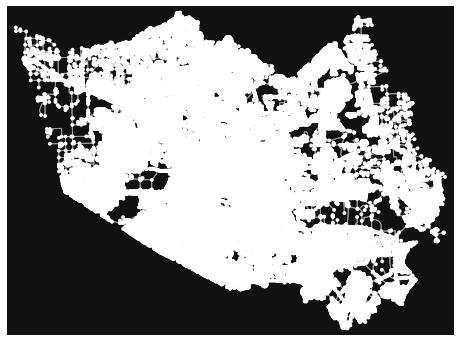

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Your code here

##  Obtain network dataset based on text
G = ox.graph_from_place('Harris County, TX, USA', network_type='drive', simplify=True)
## Change the projection of the network dataset
G = ox.project_graph(G, to_crs='epsg:5070')
ox.plot_graph(G)

Use the function below to make a backup for your network dataset. With the code in the second line, you can store it back. 

```python
    G_ = G.copy()  # Make a copy for a backup
    # G = G_.copy()  # Restore network dataset from the backup
```

In [5]:
G_ = G.copy()
# G = G_.copy()

Also, run the following code to trim your network dataset. 

Removed 1667 nodes (0.1368%) from the OSMNX network
Number of nodes: 12185
Number of edges: 16584


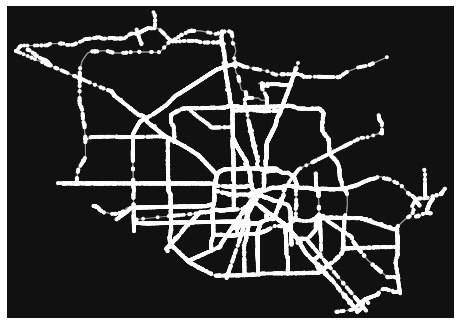

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 10:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network


# Simplify Graph: Remove edges
for u, v, data in G.copy().edges(data=True):
    if data['highway'] not in ['motorway', 'motorway_link', 
                               'trunk', 'trunk_link',
                               'primary', 'primary_link', 
#                                'secondary', 'secondary_link'  
                              ]:
        G.remove_edge(u, v)

# Simplify Graph: Remove nodes
G.remove_nodes_from(list(nx.isolates(G)))
G = remove_uncenessary_nodes(G)
ox.plot_graph(G)

When every data is ready, you will find the nearest OSM node with the following equations. Be sure that you have assigned hospital dataset as `supply`, population dataset as `demand`, and network dataset as `G`. 

In [7]:
def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf


supply = find_nearest_osm(G, supply)
demand = find_nearest_osm(G, demand)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1115/1115 [00:48<00:00, 22.80it/s]


## 2. (1.5 point) Advancement 1: Caculate the estimated travel time for each edge

First advancement is to create a catchment area based on the travel time, instead of distance. By utilizing `length` and `maxspeed` attributes in the network dataset (`G`), you can calculate the estimated travel time for each edge. 

**2.1.** (0.25 point) Investigate the contents in each row of the network dataset. You can iterate each row of the network dataset with the function below, assuming `G` is the variable of network dataset. For more information, visit <a href=https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html>G.edges()</a>.
```python
for u, v, data in G.edges(data=True):
    print(data)
```

**2.2.** (0.25 point) Create a list `collect_type`, and append the data type of `maxspeed` to the list by iterating through rows of the network dataset `G`. Given that not every row has the key `maxspeed`, you probably need to use the `if` statement. 

In [8]:
# Your code here
collect_type = []
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        collect_type.append(type(data['maxspeed']))

In [9]:
""" Check your answer here. This cell should only give you the data types (e.g., str, list)."""

print(set(collect_type))

{<class 'list'>, <class 'str'>}


**2.3.** (0.25 point) Slice only the numerical portion from the entry in `maxspeed` column. You can use `str.split()` function and list slicing to accomplish this task. <br><br>
**Note**: Most of times, the entry of `maxspeed` consists of `str` and `list`. But, it may have a different data type, such as `dict`, given that Open Street Map is a Volunteered Geographic Information (VGI). If you happen to face a different data type, consult with the instructor. 

**2.4.** (0.25 point) Assign the numerical portion of the `maxspeed` back to the original column (i.e., `data['maxspeed']`). 

In [10]:
# Your code here
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        if type(data['maxspeed']) == str:
            temp_speed = data['maxspeed'].split(' mph')[0]
            
        elif type(data['maxspeed']) == list:
            temp_speed = data['maxspeed'][0].split(' mph')[0]
            
        else:
            print(data['maxspeed'], type(data['maxspeed']))
        
        data['maxspeed'] = temp_speed

In [11]:
""" Check your answer here. This cell should only give you either number or nan value ."""

# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
print(edges['maxspeed'].unique())

[nan '65' '45' '55' '60' '50' '40' '35' '30' '15' '75' '70']


**2.5.** (0.25 point) Investigate the maximum speed of each edge based on their `highway` type. Then update the values of `max_speed_per_type` dictionary with the observed travel speed. 

For more information about the `highway` attribute, visit <a href=https://wiki.openstreetmap.org/wiki/Key:highway>OSM wiki</a>.

In [12]:
max_speed_per_type = {'motorway': 60, 
                      'motorway_link': 45, 
                      'trunk': 60,
                      'trunk_link': 45, 
                      'primary': 50,
                      'primary_link': 35, 
                      'secondary': 45,
                      'secondary_link': 35,
                      'tertiary': 40, 
                      'tertiary_link': 20,
                      'residential': 30,
                      'living_street': 20,
                      'unclassified': 20
         }

for highway_type in max_speed_per_type.keys():
    speed_per_type = edges.loc[edges['highway'] == highway_type]['maxspeed'].unique()
    print(highway_type, speed_per_type)

motorway ['65' '60' '55' nan '50' '45' '75' '70']
motorway_link [nan '55' '60' '65' '45' '40' '50' '15']
trunk ['45' nan '50' '60' '55' '40']
trunk_link [nan '40' '35']
primary [nan '45' '50' '65' '55' '40' '35' '30' '60']
primary_link [nan '50' '35' '45' '65']
secondary []
secondary_link []
tertiary []
tertiary_link []
residential [nan]
living_street []
unclassified []


**2.6.** (0.25 point) Finish the missing portion of the following `for loop`. The purpose of the following loop is to update the `maxspeed` attribute based on the `highway` attribute in case a row does not have `maxspeed` attriubte. 

**Note**: It is also possible the `highway` attribute has a `list`. Come up with your solution that can differentiate `str` and `list` to get the road type of edges.

In [13]:
for u, v, data in G.edges(data=True):
    if 'maxspeed' in data.keys():
        pass
    
    else:
        # Your code here
        if 'highway' in data.keys():
            if type(data['highway']) == list:
                temp_speed = max_speed_per_type[data['highway'][0]]
            elif type(data['highway']) == str:         
                temp_speed = max_speed_per_type[data['highway']]
        else:
            temp_speed = 20
        
        data['maxspeed'] = temp_speed

In [14]:
""" Check your answer here. This cell should only give you numbers."""

# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
print(edges['maxspeed'].unique())

[45 50 35 '65' '45' '55' '60' 60 '50' 30 '40' '35' '30' '15' '75' '70']


When all the materials are ready, run the following cell to properly assign the estimated travel time to `time` attribute of each edge. <br>

**Be sure** the `edges` dataframe has `maxspeed_meters` and `time` columns. Each column should have all the records populated. 

In [15]:
for u, v, data in G.edges(data=True):
    data['maxspeed_meters'] = int(data['maxspeed']) * 26.8223 # MPH * 1.6 * 1000 / 60; Unit: meters per minute
    data['time'] = float(data['length'] / data['maxspeed_meters'])  # Unit: minutes
    
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges

osmid  \
u          v          key                                                      
151366116  151401382  0                                 [41813061, 15276389]   
           151914215  0                                [52168001, 104104827]   
151401382  1920105641 0                                 [52158057, 41813061]   
151914215  303571309  0                               [998792472, 957572092]   
151366155  151394450  0                                             27640671   
...                                                                      ...   
8461043957 8461043958 0                     [126139954, 118082180, 15412710]   
8461043958 8461043968 0                                            953028273   
8461043968 330676254  0    [15441098, 953028273, 15412658, 126364765, 126...   
8478253606 152776279  0                    [909620608, 126392382, 126392383]   
8785685508 330095771  0                    [949080555, 126139997, 126139967]   

                                 highway  oneway    length  \
u          v          key                                    
151366116  151401382  0    motorway_link    True  1002.161   
           151914215  0    motorway_link    True   474.384   
151401382  1920105641 0    motorway_link    True   594.981   
151914215  303571309  0    motorway_link    True   222.102   
151366155  151394450  0          primary    True    52.190   
...                                  ...     ...       ...   
8461043957 8461043958 0         motorway    True   601.496   
8461043958 8461043968 0         motorway    True  1178.977   
8461043968 330676254  0         motorway    True   983.748   
8478253606 152776279  0         motorway    True   727.866   
8785685508 330095771  0         motorway    True   992.193   

                                                                    geometry  \
u          v          key                                                      
151366116  151401382  0    LINESTRING (81481.008 744707.487, 81545.700 74...   
           151914215  0    LINESTRING (81481.008 744707.487, 81501.805 74...   
151401382  1920105641 0    LINESTRING (82304.365 744448.058, 82346.029 74...   
151914215  303571309  0    LINESTRING (81312.851 744356.602, 81230.788 74...   
151366155  151394450  0    LINESTRING (81951.156 744330.176, 81977.334 74...   
...                                                                      ...   
8461043957 8461043958 0    LINESTRING (26985.066 767221.138, 27104.027 76...   
8461043958 8461043968 0    LINESTRING (27537.535 766982.617, 27935.940 76...   
8461043968 330676254  0    LINESTRING (28641.654 766573.543, 28896.432 76...   
8478253606 152776279  0    LINESTRING (35310.041 761146.885, 35344.819 76...   
8785685508 330095771  0    LINESTRING (18115.872 771078.778, 17850.068 77...   

                            lanes bridge maxspeed  maxspeed_meters      time  \
u          v          key                                                      
151366116  151401382  0         1    yes       45        1207.0035  0.830288   
           151914215  0         1    yes       45        1207.0035  0.393026   
151401382  1920105641 0         2    yes       45        1207.0035  0.492941   
151914215  303571309  0         2    yes       45        1207.0035  0.184011   
151366155  151394450  0       NaN    NaN       50        1341.1150  0.038915   
...                           ...    ...      ...              ...       ...   
8461043957 8461043958 0    [4, 3]    yes       65        1743.4495  0.345003   
8461043958 8461043968 0         3    NaN       65        1743.4495  0.676232   
8461043968 330676254  0    [5, 3]    yes       65        1743.4495  0.564254   
8478253606 152776279  0    [5, 3]    yes       65        1743.4495  0.417486   
8785685508 330095771  0         3    yes       65        1743.4495  0.569098   

                                                 name          ref access  \
u          v          key                                       

## 3. (1 point) Advancement 2: Apply distance decay functions for catchment areas

Here, we will create a function that divides a catchment area into three subzones. Then, apply a weight based on a distance decay function. For example, we will assign a high weight if the subzone is close to the supply facility, and a low weight if the subzone is far from the supply facility. 

**3.1.** (0.2 point) Update the missing information of <a href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra_path_length.html>`nx.single_source_dijkstra_path_length()`</a> function below to collect the OSM ID of the accessible nodes. <br>
**3.2.** (0.2 point) Properly slice `nodes` GeoDataFrame, which stores all the nodes of the network dataset (`G`) so that you can create a convex hull from the `accessible_nodes`. The result should be stored as `convex_hull` and its type will be `shapely.geometry.polygon.Polygon`.

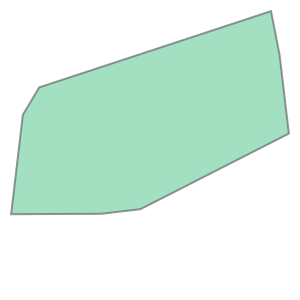

In [16]:
# Your code here
access_nodes = nx.single_source_dijkstra_path_length(G=G, 
                                                     source=supply.at[5, 'nearest_osm'], 
                                                     cutoff=10, 
                                                     weight='time'
                                                    )
convex_hull = nodes.loc[
                        nodes.index.isin(access_nodes.keys()), 'geometry'
                       ].unary_union.convex_hull

convex_hull

In [17]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
import shapely

assert type(access_nodes) == dict
assert type(convex_hull) == shapely.geometry.polygon.Polygon

print('Success!')

Success!


Now we will take advantage of `for loop` and create a series of convex hulls, which are `shapely.Polygon`. Then, we will assign them into a GeoDataFrame with its travel time as the index. 

**3.3.** (0.2 point) Utilize the codes in step 3.1. and 3.2. and complete the `for loop`. For each iteration, a different `shapely.polygon` (i.e., convex hull) will be assigned to the `geometry` column of `polygons` GeoDataFrame with is threshold travel time `minute`. 

In [18]:
minutes = [5, 10, 15]

polygons = gpd.GeoDataFrame(index=minutes, crs='EPSG:5070')

# Your code here
for minute in minutes:
    access_nodes = nx.single_source_dijkstra_path_length(G=G, 
                                                         source=supply.at[5, 'nearest_osm'], 
                                                         cutoff=minute, 
                                                         weight='time'
                                                        )
    convex_hull = nodes.loc[
                            nodes.index.isin(access_nodes.keys()), 'geometry'
                           ].unary_union.convex_hull

    polygons.at[minute, 'geometry'] = convex_hull


In [19]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(polygons) == gpd.GeoDataFrame
assert 'geometry' in polygons.columns
assert type(polygons.at[5, 'geometry']) == shapely.geometry.polygon.Polygon

print('Success!')

Success!


**3.4.** (0.2 point) Complete the following for loop to subtract a polygon (drawn from a shorter threshold travel time) from a bigger polygon (drawn with a longer threshold travel time). <a href=https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html>`gpd.overlay()`</a> will help you to finish this task. 

**Note** Be sure to make a copy of the `polygons` GeoDataFrame, and the assign the subtraction result to the copied GeoDataFrame. 

In [20]:
minutes = [5, 10, 15]

polygons_ = polygons.copy(deep=True)

# Your code here
for idx, minute in enumerate(minutes):
    if idx != 0:
        current_polygon = polygons.loc[[minute]]
        previous_polygons = polygons.loc[[minutes[idx-1]]]
        diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
        if diff_polygon.shape[0] != 0:
            polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

polygons_

,geometry
5,"POLYGON ((86123.768 718477.426, 85659.278 7186..."
10,"POLYGON ((80731.608 721755.115, 81580.066 7231..."
15,"POLYGON ((74659.850 725439.179, 75014.355 7280..."


In [21]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert not polygons_.at[5, 'geometry'].within(polygons_.at[10, 'geometry'])
assert not polygons_.at[5, 'geometry'].within(polygons_.at[15, 'geometry'])
assert not polygons_.at[10, 'geometry'].within(polygons_.at[15, 'geometry'])

print('Success!')

Success!


**3.5** (0.2 point) Complete the following function `calculate_catchment_area` with the code you worked on in the previous steps. This function will be used in the next section. It is supposed to return a GeoDataFrame which has one polygon without a hole, and two polygons with holes in it. 

In [22]:
def calculate_catchment_area(network, nearest_osm, minutes, distance_unit='time'):
    polygons = gpd.GeoDataFrame(crs='EPSG:5070')

    # Your code here
    # Create convex hull for each travel time (minutes), respectively.
    for minute in minutes:
        access_nodes = nx.single_source_dijkstra_path_length(G=network, 
                                                             source=nearest_osm, 
                                                             cutoff=minute, 
                                                             weight=distance_unit
                                                            )
        convex_hull = nodes.loc[
                                nodes.index.isin(access_nodes.keys()), 'geometry'
                               ].unary_union.convex_hull

        polygons.at[minute, 'geometry'] = convex_hull
  

    # Calculate the differences between convex hulls which created in the previous section.
    polygons_ = polygons.copy(deep=True)
    for idx, minute in enumerate(minutes):
        if idx != 0:
            current_polygon = polygons.loc[[minute]]
            previous_polygons = polygons.loc[[minutes[idx-1]]]
            diff_polygon = gpd.overlay(current_polygon, previous_polygons, how="difference")
            if diff_polygon.shape[0] != 0:
                polygons_.at[minute, 'geometry'] = diff_polygon['geometry'].values[0]

    return polygons_.copy(deep=True)

In [23]:
# Test your function here. The output should be a GeoDataFrame (index = minutes, column=geometry)
catchment_areas = calculate_catchment_area(network= G, 
                                           nearest_osm = supply.at[5, 'nearest_osm'], 
                                           minutes = [5, 10, 15], 
                                           distance_unit = 'time'
                                          )
catchment_areas

,geometry
5,"POLYGON ((86123.768 718477.426, 85659.278 7186..."
10,"POLYGON ((80731.608 721755.115, 81580.066 7231..."
15,"POLYGON ((74659.850 725439.179, 75014.355 7280..."


<AxesSubplot:>

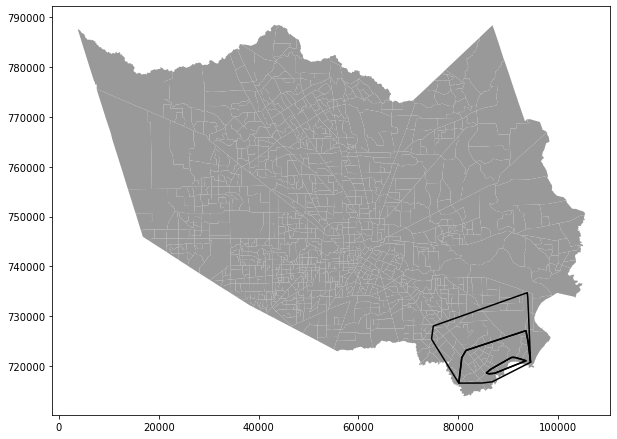

In [24]:
""" Check your answer here. This cell should NOT give any errors when it is run."""

assert type(catchment_areas) == gpd.GeoDataFrame
assert catchment_areas.shape == (3, 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

catchment_areas.boundary.plot(ax=ax, color='black', zorder=2)
demand.plot(ax=ax, color='#999999', zorder=1)

## 4. (1.5 point) Measure spatial accessibility with the advanced features

The following is the codes for the first step of the original two-step catchment area method. You need to incorporate the advanced feature (highlited in blue in the equation), which is included in `catchment_catchment_area` function, into the measurement. 

$$\huge R_j = \frac{S_j}{\sum_{k\in {\left\{\color{blue}{t_{kj}} \le \color{blue}{t_0} \right\}}}^{}{P_k}\color{blue}{W_k}}$$
where<br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$S_j$: the degree of supply (e.g., number of doctors) at location $j$. <br>
$P_k$: the degree of demand (e.g., population) at location $k$. <br>
$\color{blue}{t_{kj}}$: the travel <font color='blue'>time</font> between locations $k$ and $j$. <br>
$\color{blue}{t_0}$: the threshold travel <font color='blue'>time</font> of the analysis. <br>
$\color{blue}{W_k}$: Weight based on a distance decay function

```python

step1 = supply.copy(deep=True)
step1['ratio'] = 0

for i in trange(supply.shape[0]):
    
    # Create a catchment area from a given location
    ## Get the list of accessible nodes ID
    access_nodes = nx.single_source_dijkstra_path_length(G=G, 
                                                         source=supply.loc[i, 'nearest_osm'], 
                                                         cutoff=15, 
                                                         weight='time'
                                                        )
    ## Create a convex hull based on the points
    convex_hull = nodes.loc[nodes.index.isin(access_nodes.keys()), 'geometry'
                           ].unary_union.convex_hull

    # Calculate the population within the catchment area
    temp_demand = demand.loc[demand['geometry'].centroid.within(convex_hull), 'pop'].sum()

    # Calculate the number of hospital beds in each hospital
    temp_supply = supply.loc[i, 'BEDS']
    
    # Calculate the supply-to-demand ratio of each supply location
    step1.at[i, 'ratio'] = temp_supply / temp_demand * 100000
    
    print(f'Hospital {i}: {temp_supply} BEDS / Surrounding population: {temp_demand} / Ratio: {step1.at[i, "ratio"]}')


```


**4.1.** (0.5 point) Find the location where you can put the function `calculate_catchment_area` within this `for loop`. Since we have not applied any weight based on distance decay, the result should be the same as the original 2SFCA method. 

In [25]:
# Extract the nodes and edges of the network dataset for the future analysis. 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)

In [26]:
step1 = supply.copy(deep=True)
step1['ratio'] = 0

# Your code here 
for i in trange(supply.shape[0]):

    # Create a catchment area from a given location
    catchment_areas = calculate_catchment_area(network= G, 
                                               nearest_osm = supply.at[i, 'nearest_osm'], 
                                               minutes = [5, 10, 15], 
                                               distance_unit = 'time'
                                              )
    
    # Calculate the population within the catchment area
    catchment_pop = 0
    for idx, row in catchment_areas.iterrows():
        temp_pop = demand.loc[demand['geometry'].centroid.within(row['geometry']), 'pop'].sum()
        catchment_pop += temp_pop
        
    # Calculate the number of hospital beds in each hospital
    temp_supply = supply.loc[i, 'BEDS']
    
    # Calculate the supply-to-demand ratio of each supply location
    step1.at[i, 'ratio'] = temp_supply / catchment_pop * 100000
        
    print(f'Hospital {i}: {temp_supply} BEDS / Surrounding population: {catchment_pop} / Ratio: {step1.at[i, "ratio"]}')


  2%|██▍                                                                                                                                       | 2/115 [00:00<00:06, 16.79it/s]

Hospital 0: 205.0 BEDS / Surrounding population: 0 / Ratio: inf
Hospital 1: 64.0 BEDS / Surrounding population: 1627860 / Ratio: 3.931542024498421
Hospital 2: 864.0 BEDS / Surrounding population: 1448897 / Ratio: 59.631568013461276


  6%|████████▍                                                                                                                                 | 7/115 [00:00<00:06, 17.86it/s]

Hospital 3: 255.0 BEDS / Surrounding population: 580960 / Ratio: 43.89286697879372
Hospital 4: 208.0 BEDS / Surrounding population: 310212 / Ratio: 67.05092001598906
Hospital 5: 178.0 BEDS / Surrounding population: 192684 / Ratio: 92.37923231819974
Hospital 6: 350.0 BEDS / Surrounding population: 899747 / Ratio: 38.899824061652886


  8%|██████████▊                                                                                                                               | 9/115 [00:00<00:06, 17.43it/s]

Hospital 7: 37.0 BEDS / Surrounding population: 858087 / Ratio: 4.311917089992041
Hospital 8: 61.0 BEDS / Surrounding population: 858440 / Ratio: 7.10591305158194
Hospital 9: 358.0 BEDS / Surrounding population: 54912 / Ratio: 651.9522144522145
Hospital 10: 21.0 BEDS / Surrounding population: 473594 / Ratio: 4.434177797860615


 12%|████████████████▋                                                                                                                        | 14/115 [00:00<00:05, 17.78it/s]

Hospital 11: 193.0 BEDS / Surrounding population: 796922 / Ratio: 24.21817944541624
Hospital 12: 1128.0 BEDS / Surrounding population: 1408047 / Ratio: 80.11096220509685
Hospital 13: 313.0 BEDS / Surrounding population: 772018 / Ratio: 40.54309614542666
Hospital 14: 221.0 BEDS / Surrounding population: 1461114 / Ratio: 15.12544537934754


 16%|█████████████████████▍                                                                                                                   | 18/115 [00:01<00:05, 17.35it/s]

Hospital 15: 131.0 BEDS / Surrounding population: 1020944 / Ratio: 12.831262047673526
Hospital 16: 170.0 BEDS / Surrounding population: 434161 / Ratio: 39.15598130647387
Hospital 17: 50.0 BEDS / Surrounding population: 747189 / Ratio: 6.691747335680798
Hospital 18: 49.0 BEDS / Surrounding population: 1619083 / Ratio: 3.0264044523968194


 19%|██████████████████████████▏                                                                                                              | 22/115 [00:01<00:05, 16.36it/s]

Hospital 19: 84.0 BEDS / Surrounding population: 1008015 / Ratio: 8.333209327242155
Hospital 20: 65.0 BEDS / Surrounding population: 1475795 / Ratio: 4.404405760962735
Hospital 21: 42.0 BEDS / Surrounding population: 580960 / Ratio: 7.229413384742495
Hospital 22: 116.0 BEDS / Surrounding population: 317238 / Ratio: 36.56560689450822


 23%|██████████████████████████████▉                                                                                                          | 26/115 [00:01<00:05, 16.23it/s]

Hospital 23: 90.0 BEDS / Surrounding population: 602341 / Ratio: 14.941702457578016
Hospital 24: 60.0 BEDS / Surrounding population: 435676 / Ratio: 13.771701906921656
Hospital 25: 631.0 BEDS / Surrounding population: 1481847 / Ratio: 42.581993957540824
Hospital 26: 14.0 BEDS / Surrounding population: 0 / Ratio: inf


 26%|███████████████████████████████████▋                                                                                                     | 30/115 [00:01<00:05, 16.01it/s]

Hospital 27: 1082.0 BEDS / Surrounding population: 1259763 / Ratio: 85.88917121712576
Hospital 28: 139.0 BEDS / Surrounding population: 724431 / Ratio: 19.187472650949502
Hospital 29: 621.0 BEDS / Surrounding population: 1451442 / Ratio: 42.7850372250493


 28%|██████████████████████████████████████                                                                                                   | 32/115 [00:01<00:05, 14.41it/s]

Hospital 30: 458.0 BEDS / Surrounding population: 1479961 / Ratio: 30.9467614349297
Hospital 31: 397.0 BEDS / Surrounding population: 1409463 / Ratio: 28.166755707670223
Hospital 32: 106.0 BEDS / Surrounding population: 1316186 / Ratio: 8.05357297524818


 31%|██████████████████████████████████████████▉                                                                                              | 36/115 [00:02<00:05, 15.73it/s]

Hospital 33: 4.0 BEDS / Surrounding population: 710850 / Ratio: 0.5627066188366041
Hospital 34: 182.0 BEDS / Surrounding population: 8766 / Ratio: 2076.203513575177
Hospital 35: 16.0 BEDS / Surrounding population: 867969 / Ratio: 1.8433838074862121
Hospital 36: 547.0 BEDS / Surrounding population: 1436806 / Ratio: 38.070553714280145


 35%|███████████████████████████████████████████████▋                                                                                         | 40/115 [00:02<00:04, 15.83it/s]

Hospital 37: 116.0 BEDS / Surrounding population: 891454 / Ratio: 13.01244932436222
Hospital 38: 83.0 BEDS / Surrounding population: 853014 / Ratio: 9.730203724675093
Hospital 39: 74.0 BEDS / Surrounding population: 541827 / Ratio: 13.657495842769
Hospital 40: 12.0 BEDS / Surrounding population: 371409 / Ratio: 3.230939476426258


 38%|████████████████████████████████████████████████████▍                                                                                    | 44/115 [00:02<00:04, 14.99it/s]

Hospital 41: 25.0 BEDS / Surrounding population: 1218566 / Ratio: 2.0515917890372783
Hospital 42: 74.0 BEDS / Surrounding population: 1422088 / Ratio: 5.203616091268613
Hospital 43: 66.0 BEDS / Surrounding population: 2005126 / Ratio: 3.2915637221800527


 42%|█████████████████████████████████████████████████████████▏                                                                               | 48/115 [00:02<00:04, 15.37it/s]

Hospital 44: 88.0 BEDS / Surrounding population: 1633105 / Ratio: 5.388508393520318
Hospital 45: 24.0 BEDS / Surrounding population: 37329 / Ratio: 64.29317688660291
Hospital 46: 135.0 BEDS / Surrounding population: 1202217 / Ratio: 11.229253953321239
Hospital 47: 134.0 BEDS / Surrounding population: 1455569 / Ratio: 9.206021837508219


 45%|█████████████████████████████████████████████████████████████▉                                                                           | 52/115 [00:03<00:04, 15.70it/s]

Hospital 48: 60.0 BEDS / Surrounding population: 1172663 / Ratio: 5.116559488958038
Hospital 49: 60.0 BEDS / Surrounding population: 772018 / Ratio: 7.771839516695207
Hospital 50: 49.0 BEDS / Surrounding population: 1374211 / Ratio: 3.5656824170378494
Hospital 51: 40.0 BEDS / Surrounding population: 1210918 / Ratio: 3.30327899989925


 48%|█████████████████████████████████████████████████████████████████▌                                                                       | 55/115 [00:03<00:03, 16.93it/s]

Hospital 52: 62.0 BEDS / Surrounding population: 757197 / Ratio: 8.18809371933592
Hospital 53: 46.0 BEDS / Surrounding population: 287815 / Ratio: 15.982488751454927
Hospital 54: 20.0 BEDS / Surrounding population: 777084 / Ratio: 2.573724333534084
Hospital 55: 8.0 BEDS / Surrounding population: 89319 / Ratio: 8.956660956795307
Hospital 56: 31.0 BEDS / Surrounding population: 8766 / Ratio: 353.6390600045631


 52%|███████████████████████████████████████████████████████████████████████▍                                                                 | 60/115 [00:03<00:03, 17.67it/s]

Hospital 57: 4.0 BEDS / Surrounding population: 891294 / Ratio: 0.44878569809737306
Hospital 58: 124.0 BEDS / Surrounding population: 1422088 / Ratio: 8.719572909693353
Hospital 59: 35.0 BEDS / Surrounding population: 694352 / Ratio: 5.040671014125401
Hospital 60: 35.0 BEDS / Surrounding population: 1218566 / Ratio: 2.8722285046521896


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 64/115 [00:03<00:03, 15.99it/s]

Hospital 61: 68.0 BEDS / Surrounding population: 1907563 / Ratio: 3.5647577563624373
Hospital 62: 137.0 BEDS / Surrounding population: 1414426 / Ratio: 9.685907923072682
Hospital 63: 302.0 BEDS / Surrounding population: 1102421 / Ratio: 27.39425319365288


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 66/115 [00:04<00:03, 14.88it/s]

Hospital 64: 40.0 BEDS / Surrounding population: 1436069 / Ratio: 2.785381482366098
Hospital 65: 426.0 BEDS / Surrounding population: 1862543 / Ratio: 22.871955170967865
Hospital 66: 444.0 BEDS / Surrounding population: 1428059 / Ratio: 31.091152396364578


 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 70/115 [00:04<00:02, 15.93it/s]

Hospital 67: 40.0 BEDS / Surrounding population: 895084 / Ratio: 4.468854319818028
Hospital 68: 106.0 BEDS / Surrounding population: 772018 / Ratio: 13.730249812828198
Hospital 69: 5.0 BEDS / Surrounding population: 486019 / Ratio: 1.0287663651009529
Hospital 70: 12.0 BEDS / Surrounding population: 1770718 / Ratio: 0.6776911964525125


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 74/115 [00:04<00:02, 15.48it/s]

Hospital 71: 4.0 BEDS / Surrounding population: 66225 / Ratio: 6.04001510003775
Hospital 72: 59.0 BEDS / Surrounding population: 1186272 / Ratio: 4.973564241590462
Hospital 73: 102.0 BEDS / Surrounding population: 833072 / Ratio: 12.243839668119922
Hospital 74: 74.0 BEDS / Surrounding population: 858440 / Ratio: 8.620287964214155


 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 78/115 [00:04<00:02, 16.39it/s]

Hospital 75: 115.0 BEDS / Surrounding population: 844756 / Ratio: 13.613398425107368
Hospital 76: 75.0 BEDS / Surrounding population: 54912 / Ratio: 136.5821678321678
Hospital 77: 98.0 BEDS / Surrounding population: 1233543 / Ratio: 7.944595364733941
Hospital 78: 16.0 BEDS / Surrounding population: 1611885 / Ratio: 0.9926266452011155


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 82/115 [00:05<00:02, 15.20it/s]

Hospital 79: 96.0 BEDS / Surrounding population: 824952 / Ratio: 11.63704070054985
Hospital 80: 45.0 BEDS / Surrounding population: 422842 / Ratio: 10.642273000316903
Hospital 81: 19.0 BEDS / Surrounding population: 1622879 / Ratio: 1.1707588797439612
Hospital 82: 16.0 BEDS / Surrounding population: 835845 / Ratio: 1.914230509245135


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 86/115 [00:05<00:01, 14.65it/s]

Hospital 83: 69.0 BEDS / Surrounding population: 1409463 / Ratio: 4.8954814706026335
Hospital 84: 30.0 BEDS / Surrounding population: 1406209 / Ratio: 2.133395533665337
Hospital 85: 10.0 BEDS / Surrounding population: 1423023 / Ratio: 0.7027293304465212


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 90/115 [00:05<00:01, 15.11it/s]

Hospital 86: 744.0 BEDS / Surrounding population: 1567911 / Ratio: 47.45167295847787
Hospital 87: 430.0 BEDS / Surrounding population: 824952 / Ratio: 52.12424480454621
Hospital 88: 260.0 BEDS / Surrounding population: 1907563 / Ratio: 13.629956127268143
Hospital 89: 531.0 BEDS / Surrounding population: 434161 / Ratio: 122.30485925728014


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 92/115 [00:05<00:01, 14.94it/s]

Hospital 90: 180.0 BEDS / Surrounding population: 1008015 / Ratio: 17.856877129804616
Hospital 91: 349.0 BEDS / Surrounding population: 1453269 / Ratio: 24.01482450943356
Hospital 92: 39.0 BEDS / Surrounding population: 1030276 / Ratio: 3.7853934285570086


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 96/115 [00:06<00:01, 15.88it/s]

Hospital 93: 46.0 BEDS / Surrounding population: 1646251 / Ratio: 2.7942276117068414
Hospital 94: 293.0 BEDS / Surrounding population: 702671 / Ratio: 41.69803506904369
Hospital 95: 110.0 BEDS / Surrounding population: 434161 / Ratio: 25.33622319830662
Hospital 96: 144.0 BEDS / Surrounding population: 1379345 / Ratio: 10.439737701590248


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 100/115 [00:06<00:00, 15.86it/s]

Hospital 97: 90.0 BEDS / Surrounding population: 784824 / Ratio: 11.467539218984129
Hospital 98: 148.0 BEDS / Surrounding population: 1431086 / Ratio: 10.341796370029474
Hospital 99: 24.0 BEDS / Surrounding population: 710850 / Ratio: 3.3762397130196242
Hospital 100: 120.0 BEDS / Surrounding population: 1165560 / Ratio: 10.295480284155255


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 104/115 [00:06<00:00, 15.45it/s]

Hospital 101: 48.0 BEDS / Surrounding population: 681325 / Ratio: 7.045095952739148
Hospital 102: 7.0 BEDS / Surrounding population: 1507027 / Ratio: 0.4644906826486851
Hospital 103: 6.0 BEDS / Surrounding population: 1474935 / Ratio: 0.406797587690305


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 108/115 [00:06<00:00, 16.49it/s]

Hospital 104: 30.0 BEDS / Surrounding population: 1567911 / Ratio: 1.9133739096160431
Hospital 105: 16.0 BEDS / Surrounding population: 867969 / Ratio: 1.8433838074862121
Hospital 106: 24.0 BEDS / Surrounding population: 710850 / Ratio: 3.3762397130196242
Hospital 107: 46.0 BEDS / Surrounding population: 287815 / Ratio: 15.982488751454927


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 112/115 [00:06<00:00, 17.17it/s]

Hospital 108: 35.0 BEDS / Surrounding population: 1646251 / Ratio: 2.1260427480378143
Hospital 109: 139.0 BEDS / Surrounding population: 724431 / Ratio: 19.187472650949502
Hospital 110: 40.0 BEDS / Surrounding population: 460977 / Ratio: 8.677222507847464
Hospital 111: 40.0 BEDS / Surrounding population: 196302 / Ratio: 20.37676641093825


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:07<00:00, 16.00it/s]

Hospital 112: 22.0 BEDS / Surrounding population: 854218 / Ratio: 2.5754549775350086
Hospital 113: 12.0 BEDS / Surrounding population: 1770718 / Ratio: 0.6776911964525125
Hospital 114: 60.0 BEDS / Surrounding population: 435676 / Ratio: 13.771701906921656


Once you implement `calculate_catchment_area` and it still gives the same result, we are ready to incorporate the distance decay into the function. 

**4.2.** (0.5 point) Utilize the following `minutes` list and `weights` dictionary, to appreciate the influence of distance decay within the first step of 2SFCA method.  

```python
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}
```

In [27]:
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}

step1 = supply.copy(deep=True)
step1['ratio'] = 0

# Your code here 
for i in trange(supply.shape[0]):

    # Create a catchment area from a given location
    catchment_areas = calculate_catchment_area(network= G, 
                                               nearest_osm = supply.at[i, 'nearest_osm'], 
                                               minutes = minutes, 
                                               distance_unit = 'time'
                                              )
    
    # Calculate the population within the catchment area
    catchment_pop = 0
    for idx, row in catchment_areas.iterrows():
        temp_pop = demand.loc[demand['geometry'].centroid.within(row['geometry']), 'pop'].sum()
        catchment_pop += temp_pop * weights[idx]
        
    # Calculate the number of hospital beds in each hospital
    temp_supply = supply.loc[i, 'BEDS']
    
    # Calculate the supply-to-demand ratio of each supply location
    step1.at[i, 'ratio'] = temp_supply / catchment_pop * 100000
        
    print(f'Hospital {i}: {temp_supply} BEDS / Surrounding population: {catchment_pop} / Ratio: {step1.at[i, "ratio"]}')

step1

  0%|                                                                                                                                                  | 0/115 [00:00<?, ?it/s]

Hospital 0: 205.0 BEDS / Surrounding population: 0.0 / Ratio: inf


  2%|██▍                                                                                                                                       | 2/115 [00:00<00:06, 16.57it/s]

Hospital 1: 64.0 BEDS / Surrounding population: 768987.86 / Ratio: 8.322628136158093
Hospital 2: 864.0 BEDS / Surrounding population: 681092.3400000001 / Ratio: 126.85504582242108


  3%|████▊                                                                                                                                     | 4/115 [00:00<00:07, 15.70it/s]

Hospital 3: 255.0 BEDS / Surrounding population: 205909.22000000003 / Ratio: 123.84098196282807
Hospital 4: 208.0 BEDS / Surrounding population: 112387.32 / Ratio: 185.07425926697067


  6%|████████▍                                                                                                                                 | 7/115 [00:00<00:06, 17.48it/s]

Hospital 5: 178.0 BEDS / Surrounding population: 81110.36 / Ratio: 219.45408699949056
Hospital 6: 350.0 BEDS / Surrounding population: 405186.88 / Ratio: 86.37989463034933


  8%|██████████▊                                                                                                                               | 9/115 [00:00<00:06, 16.89it/s]

Hospital 7: 37.0 BEDS / Surrounding population: 423739.24000000005 / Ratio: 8.731785142202076
Hospital 8: 61.0 BEDS / Surrounding population: 408928.38000000006 / Ratio: 14.917037550683077
Hospital 9: 358.0 BEDS / Surrounding population: 32696.04 / Ratio: 1094.9338207318071
Hospital 10: 21.0 BEDS / Surrounding population: 198039.0 / Ratio: 10.60397194491994


 10%|██████████████▎                                                                                                                          | 12/115 [00:00<00:05, 18.23it/s]

Hospital 11: 193.0 BEDS / Surrounding population: 285693.86 / Ratio: 67.55482949476058
Hospital 12: 1128.0 BEDS / Surrounding population: 615887.98 / Ratio: 183.15018909769924


 12%|████████████████▋                                                                                                                        | 14/115 [00:00<00:05, 17.51it/s]

Hospital 13: 313.0 BEDS / Surrounding population: 238533.0 / Ratio: 131.21874122238853
Hospital 14: 221.0 BEDS / Surrounding population: 635997.28 / Ratio: 34.74857628321932


 14%|███████████████████                                                                                                                      | 16/115 [00:00<00:05, 16.52it/s]

Hospital 15: 131.0 BEDS / Surrounding population: 399317.92000000004 / Ratio: 32.805940690064695
Hospital 16: 170.0 BEDS / Surrounding population: 169278.32 / Ratio: 100.42632748245612


 16%|█████████████████████▍                                                                                                                   | 18/115 [00:01<00:05, 17.32it/s]

Hospital 17: 50.0 BEDS / Surrounding population: 224688.5 / Ratio: 22.253030306401975
Hospital 18: 49.0 BEDS / Surrounding population: 720367.28 / Ratio: 6.802085736042869


 17%|███████████████████████▊                                                                                                                 | 20/115 [00:01<00:05, 16.33it/s]

Hospital 19: 84.0 BEDS / Surrounding population: 411910.2 / Ratio: 20.392794351778615


 19%|██████████████████████████▏                                                                                                              | 22/115 [00:01<00:05, 16.12it/s]

Hospital 20: 65.0 BEDS / Surrounding population: 623440.5800000001 / Ratio: 10.426013654741562
Hospital 21: 42.0 BEDS / Surrounding population: 201471.72000000003 / Ratio: 20.846598222321223
Hospital 22: 116.0 BEDS / Surrounding population: 96701.74 / Ratio: 119.95647648118843


 21%|████████████████████████████▌                                                                                                            | 24/115 [00:01<00:05, 16.92it/s]

Hospital 23: 90.0 BEDS / Surrounding population: 214236.34000000003 / Ratio: 42.00967959030666


 23%|██████████████████████████████▉                                                                                                          | 26/115 [00:01<00:05, 16.26it/s]

Hospital 24: 60.0 BEDS / Surrounding population: 176349.24 / Ratio: 34.02339584792087
Hospital 25: 631.0 BEDS / Surrounding population: 700688.66 / Ratio: 90.05426176013752
Hospital 26: 14.0 BEDS / Surrounding population: 0.0 / Ratio: inf


 24%|█████████████████████████████████▎                                                                                                       | 28/115 [00:01<00:05, 16.48it/s]

Hospital 27: 1082.0 BEDS / Surrounding population: 506915.48 / Ratio: 213.4478118521849


 26%|███████████████████████████████████▋                                                                                                     | 30/115 [00:01<00:05, 16.17it/s]

Hospital 28: 139.0 BEDS / Surrounding population: 252660.97999999998 / Ratio: 55.01443079972223
Hospital 29: 621.0 BEDS / Surrounding population: 678471.8 / Ratio: 91.52922789126976
Hospital 30: 458.0 BEDS / Surrounding population: 667674.56 / Ratio: 68.59629337981666


 30%|████████████████████████████████████████▌                                                                                                | 34/115 [00:02<00:05, 15.70it/s]

Hospital 31: 397.0 BEDS / Surrounding population: 654121.26 / Ratio: 60.69211081749582
Hospital 32: 106.0 BEDS / Surrounding population: 470951.94000000006 / Ratio: 22.50760449144768
Hospital 33: 4.0 BEDS / Surrounding population: 320835.36 / Ratio: 1.2467453712084604
Hospital 34: 182.0 BEDS / Surrounding population: 5551.8 / Ratio: 3278.2160740660684


 32%|████████████████████████████████████████████                                                                                             | 37/115 [00:02<00:04, 16.56it/s]

Hospital 35: 16.0 BEDS / Surrounding population: 409483.36 / Ratio: 3.9073626825764056
Hospital 36: 547.0 BEDS / Surrounding population: 678199.26 / Ratio: 80.65476214173398
Hospital 37: 116.0 BEDS / Surrounding population: 284280.04000000004 / Ratio: 40.80483455679828


 34%|██████████████████████████████████████████████▍                                                                                          | 39/115 [00:02<00:04, 16.50it/s]

Hospital 38: 83.0 BEDS / Surrounding population: 344493.12 / Ratio: 24.09336941184776


 37%|██████████████████████████████████████████████████                                                                                       | 42/115 [00:02<00:04, 16.90it/s]

Hospital 39: 74.0 BEDS / Surrounding population: 225398.12 / Ratio: 32.83079734649073
Hospital 40: 12.0 BEDS / Surrounding population: 135029.68 / Ratio: 8.886935079754318
Hospital 41: 25.0 BEDS / Surrounding population: 538649.94 / Ratio: 4.641233228393194
Hospital 42: 74.0 BEDS / Surrounding population: 656405.7000000001 / Ratio: 11.273515754052713


 40%|██████████████████████████████████████████████████████▊                                                                                  | 46/115 [00:02<00:04, 16.81it/s]

Hospital 43: 66.0 BEDS / Surrounding population: 861276.84 / Ratio: 7.663041305046586
Hospital 44: 88.0 BEDS / Surrounding population: 589663.3 / Ratio: 14.92377090451449
Hospital 45: 24.0 BEDS / Surrounding population: 11313.24 / Ratio: 212.14081907570247
Hospital 46: 135.0 BEDS / Surrounding population: 518022.16000000003 / Ratio: 26.06066118870281


 43%|███████████████████████████████████████████████████████████▌                                                                             | 50/115 [00:03<00:03, 16.69it/s]

Hospital 47: 134.0 BEDS / Surrounding population: 661814.68 / Ratio: 20.247359880261342
Hospital 48: 60.0 BEDS / Surrounding population: 509910.5 / Ratio: 11.766770835274034
Hospital 49: 60.0 BEDS / Surrounding population: 238533.0 / Ratio: 25.153752311000993
Hospital 50: 49.0 BEDS / Surrounding population: 625886.2 / Ratio: 7.828899247179439


 47%|████████████████████████████████████████████████████████████████▎                                                                        | 54/115 [00:03<00:03, 16.93it/s]

Hospital 51: 40.0 BEDS / Surrounding population: 598401.42 / Ratio: 6.684476116383546
Hospital 52: 62.0 BEDS / Surrounding population: 264452.94 / Ratio: 23.4446249680567
Hospital 53: 46.0 BEDS / Surrounding population: 82275.9 / Ratio: 55.90944614401059
Hospital 54: 20.0 BEDS / Surrounding population: 364402.22000000003 / Ratio: 5.488440767457454


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 58/115 [00:03<00:03, 18.23it/s]

Hospital 55: 8.0 BEDS / Surrounding population: 28277.940000000002 / Ratio: 28.29060391244907
Hospital 56: 31.0 BEDS / Surrounding population: 5551.8 / Ratio: 558.3774631650996
Hospital 57: 4.0 BEDS / Surrounding population: 326953.5 / Ratio: 1.2234155621518044
Hospital 58: 124.0 BEDS / Surrounding population: 656405.7000000001 / Ratio: 18.890756128412654


 54%|█████████████████████████████████████████████████████████████████████████▊                                                               | 62/115 [00:03<00:03, 16.17it/s]

Hospital 59: 35.0 BEDS / Surrounding population: 255136.34000000003 / Ratio: 13.718155555574716
Hospital 60: 35.0 BEDS / Surrounding population: 538649.94 / Ratio: 6.497726519750471
Hospital 61: 68.0 BEDS / Surrounding population: 855506.92 / Ratio: 7.948503794685846


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 64/115 [00:03<00:03, 15.97it/s]

Hospital 62: 137.0 BEDS / Surrounding population: 623772.6000000001 / Ratio: 21.963132077298678
Hospital 63: 302.0 BEDS / Surrounding population: 485392.64 / Ratio: 62.21767186251525
Hospital 64: 40.0 BEDS / Surrounding population: 670688.3 / Ratio: 5.964022333474432


 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 68/115 [00:04<00:03, 15.13it/s]

Hospital 65: 426.0 BEDS / Surrounding population: 794034.7400000001 / Ratio: 53.65004558868545
Hospital 66: 444.0 BEDS / Surrounding population: 610174.94 / Ratio: 72.76601690656126
Hospital 67: 40.0 BEDS / Surrounding population: 300685.74 / Ratio: 13.302925506211237
Hospital 68: 106.0 BEDS / Surrounding population: 238533.0 / Ratio: 44.43829574943509


 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 72/115 [00:04<00:02, 16.31it/s]

Hospital 69: 5.0 BEDS / Surrounding population: 178207.40000000002 / Ratio: 2.8057196278044567
Hospital 70: 12.0 BEDS / Surrounding population: 891181.26 / Ratio: 1.3465274168803774
Hospital 71: 4.0 BEDS / Surrounding population: 23303.239999999998 / Ratio: 17.16499508222891
Hospital 72: 59.0 BEDS / Surrounding population: 508936.86 / Ratio: 11.59279365224205


 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 76/115 [00:04<00:02, 16.81it/s]

Hospital 73: 102.0 BEDS / Surrounding population: 294882.42000000004 / Ratio: 34.590057962763595
Hospital 74: 74.0 BEDS / Surrounding population: 411315.58 / Ratio: 17.991052028712357
Hospital 75: 115.0 BEDS / Surrounding population: 396524.32 / Ratio: 29.0020042150252
Hospital 76: 75.0 BEDS / Surrounding population: 32696.04 / Ratio: 229.38557696895404


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 80/115 [00:04<00:02, 16.36it/s]

Hospital 77: 98.0 BEDS / Surrounding population: 475448.74 / Ratio: 20.612106365031067
Hospital 78: 16.0 BEDS / Surrounding population: 680596.96 / Ratio: 2.3508773827023854
Hospital 79: 96.0 BEDS / Surrounding population: 380387.0 / Ratio: 25.237455538701376
Hospital 80: 45.0 BEDS / Surrounding population: 169886.7 / Ratio: 26.488241869434155


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 84/115 [00:05<00:01, 15.84it/s]

Hospital 81: 19.0 BEDS / Surrounding population: 798382.68 / Ratio: 2.379811145201697
Hospital 82: 16.0 BEDS / Surrounding population: 386929.46 / Ratio: 4.135120649639859
Hospital 83: 69.0 BEDS / Surrounding population: 654121.26 / Ratio: 10.548502887675596


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 88/115 [00:05<00:01, 15.30it/s]

Hospital 84: 30.0 BEDS / Surrounding population: 641440.3200000001 / Ratio: 4.67697446895761
Hospital 85: 10.0 BEDS / Surrounding population: 743515.9 / Ratio: 1.344961150124698
Hospital 86: 744.0 BEDS / Surrounding population: 636889.68 / Ratio: 116.81771951462613
Hospital 87: 430.0 BEDS / Surrounding population: 380387.0 / Ratio: 113.04276960043323


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 92/115 [00:05<00:01, 15.46it/s]

Hospital 88: 260.0 BEDS / Surrounding population: 855506.92 / Ratio: 30.391338038504703
Hospital 89: 531.0 BEDS / Surrounding population: 169278.32 / Ratio: 313.6845876069658
Hospital 90: 180.0 BEDS / Surrounding population: 411910.2 / Ratio: 43.69884503952561
Hospital 91: 349.0 BEDS / Surrounding population: 662353.04 / Ratio: 52.690933523910445


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 96/115 [00:05<00:01, 16.32it/s]

Hospital 92: 39.0 BEDS / Surrounding population: 393853.12 / Ratio: 9.902168605392793
Hospital 93: 46.0 BEDS / Surrounding population: 688442.88 / Ratio: 6.681745332307017
Hospital 94: 293.0 BEDS / Surrounding population: 332477.86 / Ratio: 88.12616876203427
Hospital 95: 110.0 BEDS / Surrounding population: 175523.14 / Ratio: 62.66979954893696


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 100/115 [00:06<00:00, 16.10it/s]

Hospital 96: 144.0 BEDS / Surrounding population: 628540.48 / Ratio: 22.910218924960887
Hospital 97: 90.0 BEDS / Surrounding population: 359665.06000000006 / Ratio: 25.023281382962242
Hospital 98: 148.0 BEDS / Surrounding population: 674158.8 / Ratio: 21.953284597041527
Hospital 99: 24.0 BEDS / Surrounding population: 320835.36 / Ratio: 7.480472227250763


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 104/115 [00:06<00:00, 15.69it/s]

Hospital 100: 120.0 BEDS / Surrounding population: 482771.66000000003 / Ratio: 24.85647148384808
Hospital 101: 48.0 BEDS / Surrounding population: 230324.26 / Ratio: 20.840184182074438
Hospital 102: 7.0 BEDS / Surrounding population: 639816.5800000001 / Ratio: 1.0940635517760415
Hospital 103: 6.0 BEDS / Surrounding population: 570237.48 / Ratio: 1.0521932020322482


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 106/115 [00:06<00:00, 15.70it/s]

Hospital 104: 30.0 BEDS / Surrounding population: 636889.68 / Ratio: 4.710391915912344
Hospital 105: 16.0 BEDS / Surrounding population: 409483.36 / Ratio: 3.9073626825764056
Hospital 106: 24.0 BEDS / Surrounding population: 320835.36 / Ratio: 7.480472227250763
Hospital 107: 46.0 BEDS / Surrounding population: 82275.9 / Ratio: 55.90944614401059


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 111/115 [00:06<00:00, 17.26it/s]

Hospital 108: 35.0 BEDS / Surrounding population: 688442.88 / Ratio: 5.0839366658857745
Hospital 109: 139.0 BEDS / Surrounding population: 252660.97999999998 / Ratio: 55.01443079972223
Hospital 110: 40.0 BEDS / Surrounding population: 144976.02000000002 / Ratio: 27.590769839039584
Hospital 111: 40.0 BEDS / Surrounding population: 71030.42000000001 / Ratio: 56.31390043871344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:07<00:00, 16.42it/s]

Hospital 112: 22.0 BEDS / Surrounding population: 430987.44 / Ratio: 5.104557107279042
Hospital 113: 12.0 BEDS / Surrounding population: 891181.26 / Ratio: 1.3465274168803774
Hospital 114: 60.0 BEDS / Surrounding population: 176349.24 / Ratio: 34.02339584792087


,ID,NAME,CITY,ZIP,BEDS,geometry,nearest_osm,ratio
0,0004677521,HOUSTON METHODIST BAYTOWN HOSPITAL,BAYTOWN,77521,205.0,POINT (98611.340 744289.745),1.525410e+08,inf
1,0006177401,MEMORIAL HERMANN ORTHOPEDIC AND SPINE HOSPITAL,BELLAIRE,77401,64.0,POINT (52103.134 738882.708),7.575438e+09,8.322628
2,0026377030,CHI ST LUKES HEALTH BAYLOR COLLEGE OF MEDICINE...,GRANBURY,77030,864.0,POINT (57991.445 737135.318),5.524452e+08,126.855046
3,0029877091,MEMORIAL HERMANN NORTHEAST HOSPITAL,HUMBLE,77338,255.0,POINT (69772.295 769142.888),1.519905e+08,123.840982
4,0031677494,MEMORIAL HERMANN KATY HOSPITAL,KATY,77494,208.0,POINT (20654.913 745801.658),1.388462e+09,185.074259
...,...,...,...,...,...,...,...,...
110,0196784220,ENCOMPASS HEALTH REHABILITATION HOSPITAL OF KATY,KATY,77494,40.0,POINT (21492.685 743615.502),1.526909e+08,27.590770
111,0196784233,MEMORIAL HERMANN CYPRESS HOSPITAL,CYPRESS,77433,40.0,POINT (25807.722 767906.156),1.531870e+08,56.313900
112,0196784244,OCEANS BEHAVIORAL HOSPITAL OF PASADENA,PASADENA,77505,22.0,POINT (80334.634 730996.324),5.180927e+09,5.104557
113,0196784247,RIVER OAKS HOSPITALS & CLINICS,HOUSTON,77027,12.0,POINT (53672.673 739692.039),1.521189e+08,1.346527


In the same manner, the following code is the second step of the original 2SFCA method. Modify this to have `calculate_catchment_area`. 

$$\huge A_i = \sum_{j\in {\left\{\color{blue}{t_{ij}} \le \color{blue}{t_0} \right\}}} R_j\color{blue}{W_j}$$
where<br>
$A_i$: the accessibility measures at location $i$. <br>
$R_j$: the supply-to-demand ratio of location $j$. <br>
$\color{blue}{W_j}$: Weight based on a distance decay function<br>

```python
step2 = demand.copy(deep=True)
step2['access'] = 0

for j in trange(demand.shape[0]):
    
    # Create a catchment area from a given location
    ## Get the list of accessible nodes ID
    access_nodes = nx.single_source_dijkstra_path_length(G=G, 
                                                         source=demand.loc[j, 'nearest_osm'], 
                                                         cutoff=15, 
                                                         weight='time'
                                                        )
    
    ## Create a convex hull based on the points
    convex_hull = nodes.loc[nodes.index.isin(access_nodes.keys()), 'geometry'
                           ].unary_union.convex_hull

    # Calculate the population within the catchment area
    temp_ratio = step1.loc[step1['geometry'].centroid.within(convex_hull), 'ratio'].sum()
    
    # Assign the accumulated ratio of accessible supply facilities to each demand location
    step2.at[j, 'access'] = temp_ratio

```


**4.3.** (0.5 point) Implement `calculate_catchment_area` function and utilize the following `minutes` list and `weights` dictionary, to appreciate the influence of distance decay within the second step of 2SFCA method. 

```python
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}
```

In [28]:
minutes = [5, 10, 15]
weights = {5: 1, 10: 0.68, 15: 0.22}

step2 = demand.copy(deep=True)
step2['access'] = 0

## Your code here
for j in trange(demand.shape[0]):
    # Create a catchment area from a given location
    catchment_areas = calculate_catchment_area(network= G, 
                                               nearest_osm = demand.loc[j, 'nearest_osm'], 
                                               minutes = minutes, 
                                               distance_unit = 'time'
                                              )
    
    # Calculate the population within the catchment area
    catchment_ratio = 0
    for idx, row in catchment_areas.iterrows():
        temp_ratio = step1.loc[step1['geometry'].centroid.within(row['geometry']), 'ratio'].sum()
        catchment_ratio += temp_ratio * weights[idx]
        
    # Assign the accumulated ratio of accessible supply facilities to each demand location
    step2.at[j, 'access'] = catchment_ratio
    
step2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1115/1115 [00:32<00:00, 34.30it/s]


,GEOID,pop,geometry,nearest_osm,access
0,48201233105,3734,"POLYGON ((80205.494 746468.105, 80459.750 7464...",1.525062e+08,inf
1,48201252201,4838,"POLYGON ((79647.402 751105.707, 79689.899 7511...",1.577032e+09,69.215712
2,48201232404,3652,"POLYGON ((76200.692 751116.046, 76346.604 7511...",1.516957e+08,91.030861
3,48201232203,5924,"POLYGON ((70542.932 762253.345, 70549.541 7622...",1.525045e+08,218.731947
4,48201232306,3644,"POLYGON ((75877.706 753056.961, 76013.176 7530...",1.516957e+08,92.067147
...,...,...,...,...,...
1110,48201453601,2161,"POLYGON ((39094.332 734967.618, 39208.292 7349...",1.529061e+08,406.717873
1111,48201453501,6357,"POLYGON ((38998.564 731816.263, 39001.902 7318...",1.521190e+08,483.171846
1112,48201453502,3926,"POLYGON ((38274.094 733159.624, 38281.607 7332...",1.521190e+08,483.171846
1113,48201553401,4556,"POLYGON ((51384.770 773740.574, 51447.287 7737...",1.515564e+08,326.807188


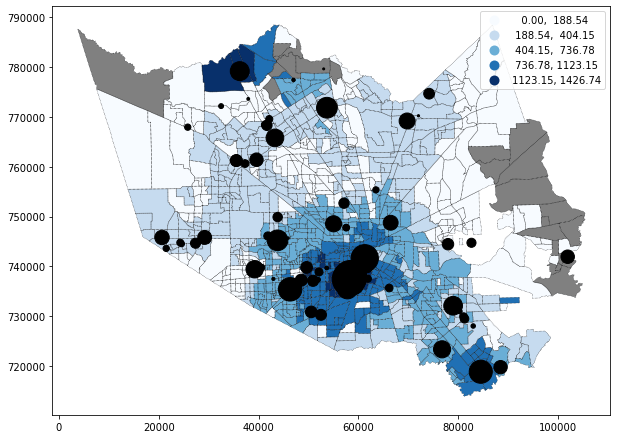

Success!


In [29]:
""" Check your answer here. This cell should NOT give any errors when it is run."""
fig, ax = plt.subplots(figsize=(10,10))

step1 = step1[~step1.isin([np.nan, np.inf, -np.inf]).any(1)]
step2 = step2[~step2.isin([np.nan, np.inf, -np.inf]).any(1)]

step1.plot(markersize='BEDS', ax=ax, zorder=2, color='black')
step2.plot('access', ax=ax, legend=True, cmap='Blues', scheme='FisherJenks', zorder=1)
step2.loc[step2['access'] == 0].plot(ax=ax, color='grey', zorder=1)
step2.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=2)

plt.show()

print('Success!')

### *You have finished Lab 7: Advance Spatial Accessibility Measurements*

Please name your jupyter notebook as `GEOG489_Lab7_[YOUR_NET_ID].ipynb`, and upload it to https://learn.illinois.edu **ALONG WITH YOUR DATA**.